In [1]:
import tensorflow as tf
import numpy as np

class Model_vec:
    
    def __init__(self, bow_shape, batch_size, dimension_size, learning_rate, vocabulary_size, boundary):
        self.X = tf.placeholder(tf.float32, shape=[batch_size, bow_shape])
        self.Y = tf.placeholder(tf.int32, shape=[batch_size, 1])
        embeddings = tf.Variable(tf.random_uniform([bow_shape, dimension_size], boundary[0], boundary[1]))
        embeddings = tf.matmul(self.X, embeddings)
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, dimension_size], stddev = 1.0 / np.sqrt(dimension_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights, biases = nce_biases, labels = self.Y,
                                                  inputs = embeddings, num_sampled = batch_size, num_classes = vocabulary_size))

        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
        self.normalized_embeddings = embeddings / norm

In [2]:
learning_rate = 0.001
boundary = [-1, 1]
batch_size = 20
dimension_size = 300
epoch = 10

In [3]:
import sklearn.datasets
import re
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# clear string
def clearstring(string):
    string = re.sub('[^A-Za-z ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = ' '.join(string)
    return string.lower()

# because of sklean.datasets read a document as a single element
# so we want to split based on new line
def separate_dataset(trainset):
    datastring = []
    datatarget = []
    for i in range(len(trainset.data)):
        data_ = trainset.data[i].split('\n')
        # python3, if python2, just remove list()
        data_ = list(filter(None, data_))
        for n in range(len(data_)):
            data_[n] = clearstring(data_[n])
        datastring += data_
        for n in range(len(data_)):
            datatarget.append(trainset.target[i])
    return datastring, datatarget

In [5]:
# you can change any encoding type
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
416809
416809


In [6]:
import random
combined = list(zip(trainset.data, trainset.target))
random.shuffle(combined)

trainset.data[:], trainset.target[:] = zip(*combined)

In [7]:
bow = CountVectorizer(min_df=10).fit(trainset.data)
out = bow.transform(trainset.data)

In [8]:
label_Y = np.array(trainset.target).reshape((-1, 1))

In [9]:
sess = tf.InteractiveSession()
model = Model_vec(out.shape[1], batch_size, dimension_size, learning_rate, out.shape[0], boundary)
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    total_loss = 0
    for k in range(0, (out.shape[0] // batch_size) * batch_size, batch_size):
        loss, _ = sess.run([model.loss, model.optimizer], feed_dict = {model.X: out[k: k + batch_size, :].todense(),
                                                                       model.Y: label_Y[k: k + batch_size, :]})
    total_loss += loss
    print('epoch: ', i, 'avg loss: ', total_loss / (out.shape[0] // batch_size))

epoch:  0 avg loss:  0.00331325970318
epoch:  1 avg loss:  0.00242805627395
epoch:  2 avg loss:  0.00134093601278
epoch:  3 avg loss:  0.00176551053712
epoch:  4 avg loss:  0.0016130959919
epoch:  5 avg loss:  0.00206702043823
epoch:  6 avg loss:  0.000990094150097
epoch:  7 avg loss:  0.000851506143522
epoch:  8 avg loss:  0.000532992375789
epoch:  9 avg loss:  0.00111142980389
epoch:  10 avg loss:  0.00103610737996


KeyboardInterrupt: 

In [11]:
vectorized = np.zeros(((out.shape[0] // batch_size) * batch_size, dimension_size))

In [13]:
for k in range(0, (out.shape[0] // batch_size) * batch_size, batch_size):
    vectorized[k: k + batch_size, :] = sess.run(model.normalized_embeddings, feed_dict = {model.X: out[k: k + batch_size, :].todense()})

In [30]:
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
_, vect_temp, _, Y_temp = train_test_split(vectorized, trainset.target[:vectorized.shape[0]], test_size = 0.005)

In [31]:
embed_2d = TSNE(n_components = 2).fit_transform(vect_temp)

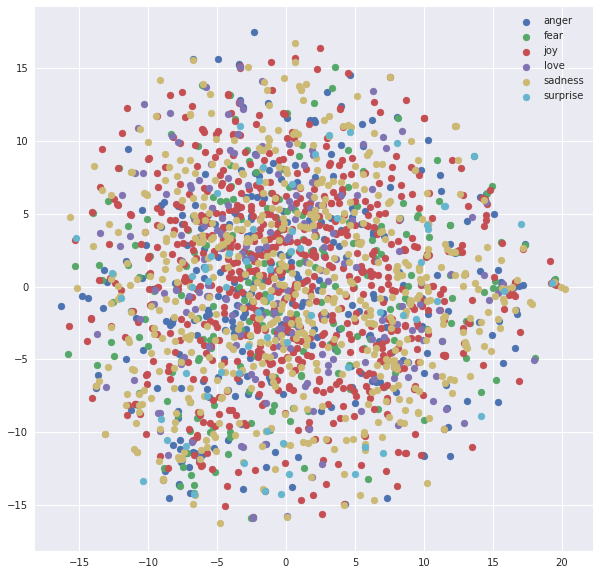

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 10))
colors = sns.color_palette(n_colors = len(trainset.target_names))
y_train_reshape = np.array(Y_temp)
for no, _ in enumerate(np.unique(y_train_reshape)):
    plt.scatter(embed_2d[y_train_reshape == no, 0], embed_2d[y_train_reshape == no, 1], c = colors[no], label = trainset.target_names[no])
plt.legend()
plt.show()

In [34]:
import pickle
with open('vector.p', 'wb') as fopen:
    pickle.dump(vectorized, fopen)
with open('label-y.p', 'wb') as fopen:
    pickle.dump(trainset.target[:vectorized.shape[0]], fopen)

In [35]:
train_X, test_X, train_Y, test_Y = train_test_split(vectorized, trainset.target[:vectorized.shape[0]], test_size = 0.2)

In [36]:
import lightgbm as lgb
params_lgd = {
    'boosting_type': 'dart',
    'objective': 'multiclass',
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'silent': False,
    'n_estimators': 10000,
    'reg_lambda': 0.0005,
    'device':'gpu'
    }
clf = lgb.LGBMClassifier(**params_lgd)
clf.fit(train_X,train_Y, eval_set=[(train_X,train_Y), (test_X,test_Y)], 
        eval_metric='logloss', early_stopping_rounds=20, verbose=True)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[1]	valid_0's multi_logloss: 1.76132	valid_1's multi_logloss: 1.76207
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 1.73429	valid_1's multi_logloss: 1.73585
[3]	valid_0's multi_logloss: 1.71066	valid_1's multi_logloss: 1.71288
[4]	valid_0's multi_logloss: 1.6893	valid_1's multi_logloss: 1.69238
[5]	valid_0's multi_logloss: 1.67051	valid_1's multi_logloss: 1.67433
[6]	valid_0's multi_logloss: 1.65326	valid_1's multi_logloss: 1.65775
[7]	valid_0's multi_logloss: 1.63799	valid_1's multi_logloss: 1.64308
[8]	valid_0's multi_logloss: 1.64465	valid_1's multi_logloss: 1.64946
[9]	valid_0's multi_logloss: 1.62993	valid_1's multi_logloss: 1.63536
[10]	valid_0's multi_logloss: 1.61651	valid_1's multi_logloss: 1.62253
[11]	valid_0's multi_logloss: 1.60429	valid_1's multi_logloss: 1.61085
[12]	valid_0's multi_logloss: 1.609	valid_1's multi_logloss: 1.61533
[13]	valid_0's multi_logloss: 1.59745	valid_1's multi_logloss: 1.6044
[14]	valid_0's multi_logloss

[116]	valid_0's multi_logloss: 1.43052	valid_1's multi_logloss: 1.45596
[117]	valid_0's multi_logloss: 1.43186	valid_1's multi_logloss: 1.45712
[118]	valid_0's multi_logloss: 1.42876	valid_1's multi_logloss: 1.45449
[119]	valid_0's multi_logloss: 1.43019	valid_1's multi_logloss: 1.4557
[120]	valid_0's multi_logloss: 1.43187	valid_1's multi_logloss: 1.45715
[121]	valid_0's multi_logloss: 1.43353	valid_1's multi_logloss: 1.45859
[122]	valid_0's multi_logloss: 1.43528	valid_1's multi_logloss: 1.4601
[123]	valid_0's multi_logloss: 1.43211	valid_1's multi_logloss: 1.45744
[124]	valid_0's multi_logloss: 1.4291	valid_1's multi_logloss: 1.45487
[125]	valid_0's multi_logloss: 1.43058	valid_1's multi_logloss: 1.45614
[126]	valid_0's multi_logloss: 1.43214	valid_1's multi_logloss: 1.4575
[127]	valid_0's multi_logloss: 1.42908	valid_1's multi_logloss: 1.45494
[128]	valid_0's multi_logloss: 1.43053	valid_1's multi_logloss: 1.45619
[129]	valid_0's multi_logloss: 1.42747	valid_1's multi_logloss: 1.45

LGBMClassifier(boosting_type='dart', colsample_bytree=0.4, device='gpu',
        learning_rate=0.1, max_bin=255, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
        n_jobs=-1, num_leaves=31, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0005, silent=False,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=1)

In [37]:
from sklearn import metrics
predicted = clf.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))

# print scores
print(metrics.classification_report(test_Y, predicted, target_names = trainset.target_names))

accuracy validation set:  0.45790547025
             precision    recall  f1-score   support

      anger       0.73      0.06      0.12     11574
       fear       0.76      0.05      0.10      9464
        joy       0.44      0.83      0.57     27958
       love       0.86      0.01      0.01      7033
    sadness       0.48      0.56      0.51     24322
   surprise       0.80      0.02      0.04      3009

avg / total       0.58      0.46      0.37     83360

